# 1차 헤커톤 데이터 분석하기

주제: [League of Legends Diamond Ranked Games (10 min)
](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min)   
리그오브레전드 다이아 랭크게임 10분까지 데이터를 보고 결과 예측하기

---

운 좋게 실리콘벨리에서 근무하고 계시는 정현준님 세미나를 듣게 됐는데, 그 때 데이터 분석 CDA에 대해 알게 되었다. 둘의 특징을 정리해봤다.   

- CDA: 이미 갖고 있는 인사이트나 가설을 검증하기 위해 데이터를 분석한다. 하지만 해당 가설의 검증 결과에 집중하기 위해 유의미한 인사이트를 주는 지표를 놓칠 수 있다.
- EDA: 데이터를 선입견 없이 유연하게 탐색해본다. 반대로 생각해보면 명확한 분석 목표가 없어 방황할 수 있다.

![](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbjxLqR%2FbtrmNokfrS0%2FWsGuSlQZTOUw21FUeyRmdK%2Fimg.png)

CDA 방식을 사용해서 데이터를 분석하면 features들이 얼마나 영향을 미치는지 볼 수 있다고 얘기해주신게 기억에 남아, 기존에 많이 경험해본 EDA(탐색적 자료 분석) 방식이 아닌 CDA(확증적 자료 분석) 방식을 통해 데이터를 풀어내기 위해 노력했다.   
처음부터 가설을 설정하고 데이터를 수집한게 아닌 갖고 있는 데이터를 활용한다는 점이 아쉽지만, 주어진 데이터에 가설을 제시하고 이에 대한 타당성을 검토하고 분석하는 과정을 거쳤다.


다양한 데이터셋(리그 오브 레전드, 코로나, 전력사용량, 넷플릭스, KBO)중 리그 오브 레전드 데이터셋을 선택한 가장 큰 이유는 내가 갖고 있는 인사이트를 통해 가설을 세울 때 친숙하여 접근성이 가장 크다고 생각했다. 그리고 타겟값이 승리 혹은 패배로 확실해 가설을 정리하기에 비교적 좋아보였다.

# 1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics

In [2]:
csv_path = os.getenv('HOME')+'/aiffel/datathon/lol_data/data/high_diamond_ranked_10min.csv'
df = pd.read_csv(csv_path)

df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
df.shape

(9879, 40)

features들이 갖는 대소관계를 통해 현재 우위 상황을 판단하고 entropy를 나타내는 decision tree 적용하기   
특히 이는 features들의 값들이 갖고 있는 정보 이득을 비교 및 확인할 수 있음   

만약 위와 같은 가설을 적용할 경우 해야하는 투두 리스트
1. 대소관계를 표현할 수 있는 features들만 남기기
2. 남긴 정보들의 오차를 계산해서 새로운 columns를 만들기

---

먼저 raw data들로 결과를 보고싶어서 따로 전처리 없이 진행하기   
여기서 target값인 `blueWins`랑 고유의 ID값을 갖고 있는 `gameId` columns는 제외하고 진행하자

In [4]:
df.columns, df.columns.shape

(Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
        'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
        'blueEliteMonsters', 'blueDragons', 'blueHeralds',
        'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
        'blueTotalExperience', 'blueTotalMinionsKilled',
        'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
        'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
        'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
        'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
        'redTotalGold', 'redAvgLevel', 'redTotalExperience',
        'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
        'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
       dtype='object'),
 (40,))

In [5]:
using_cols = df.columns.copy()

In [6]:
df[using_cols].corr()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
gameId,1.000000,0.000985,0.005361,-0.012057,-0.011577,-0.038993,-0.013160,-0.023329,0.016599,0.008962,...,0.003557,-0.010622,-0.012419,-0.021187,-0.005118,0.006040,0.014670,0.012315,-0.005118,-0.010622
blueWins,0.000985,1.000000,0.000087,0.044247,0.201769,0.337358,-0.339297,0.276685,0.221944,0.213768,...,-0.103696,-0.411396,-0.352127,-0.387588,-0.212171,-0.110994,-0.511119,-0.489558,-0.212171,-0.411396
blueWardsPlaced,0.005361,0.000087,1.000000,0.034447,0.003228,0.018138,-0.002612,0.033217,0.019892,0.017676,...,-0.008225,-0.005685,-0.008882,-0.013000,-0.012395,0.001224,-0.015800,-0.027943,-0.012395,-0.005685
blueWardsDestroyed,-0.012057,0.044247,0.034447,1.000000,0.017717,0.033748,-0.073182,0.067793,0.041700,0.040504,...,-0.023943,-0.067467,-0.059090,-0.057314,0.040023,-0.035732,-0.078585,-0.077946,0.040023,-0.067467
blueFirstBlood,-0.011577,0.201769,0.003228,0.017717,1.000000,0.269425,-0.247929,0.229485,0.151603,0.134309,...,-0.069584,-0.301479,-0.182602,-0.194920,-0.156711,-0.024559,-0.378511,-0.240665,-0.156711,-0.301479
blueKills,-0.038993,0.337358,0.018138,0.033748,0.269425,1.000000,0.004044,0.813667,0.178540,0.170436,...,-0.082491,-0.161127,-0.412219,-0.462333,-0.472203,-0.214454,-0.654148,-0.583730,-0.472203,-0.161127
blueDeaths,-0.013160,-0.339297,-0.002612,-0.073182,-0.247929,0.004044,1.000000,-0.026372,-0.204764,-0.188852,...,0.156780,0.885728,0.433383,0.464584,-0.040521,-0.100271,0.640000,0.577613,-0.040521,0.885728
blueAssists,-0.023329,0.276685,0.033217,0.067793,0.229485,0.813667,-0.026372,1.000000,0.149043,0.170873,...,-0.060880,-0.133948,-0.356928,-0.396652,-0.337515,-0.160915,-0.549761,-0.437002,-0.337515,-0.133948
blueEliteMonsters,0.016599,0.221944,0.019892,0.041700,0.151603,0.178540,-0.204764,0.149043,1.000000,0.781039,...,-0.052029,-0.216616,-0.169649,-0.189816,-0.074838,-0.087893,-0.281464,-0.263991,-0.074838,-0.216616
blueDragons,0.008962,0.213768,0.017676,0.040504,0.134309,0.170436,-0.188852,0.170873,0.781039,1.000000,...,-0.032865,-0.192871,-0.149806,-0.159485,-0.059803,-0.098446,-0.233875,-0.211496,-0.059803,-0.192871


In [7]:
cols = ['gameId', 'blueWins', 'redFirstBlood', 'redKills', 'redEliteMonsters', 'redDragons','redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'redGoldDiff', 'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin', 'redHeralds',
       'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin', 'blueWardsPlaced', 'blueFirstBlood', 'blueDeaths'
       ,'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience',
       'blueTotalMinionsKilled','redWardsPlaced', 'redWardsDestroyed', 'redDeaths', 'redAssists', 
       'redTowersDestroyed', 'redTotalGold', 'redAvgLevel', 'redTotalExperience', 'blueWardsDestroyed', 'blueKills']
using_cols = using_cols.drop(cols)

# 정글러의 영향력

- 봇라인의 경우 2대2에서 2대3이 될 경우 둘다 죽을 활률이 올라간다.
- 초반 10분에는 정글의 영향력이 매우 크다 봄(라인 전의 경우 어차피 손 차이)
- 필요 데이터
    1. 블루 정글 몬스터 킬수, 블루 드래곤 처치, 블루팀(레드 블루 초반 10분은 거의 정글꺼), 블루팀 전령
    2. 정글 몬스터 킬수의 차, 드래곤 처치의 차, 엘리트 몬스터 처치차, 전령 처치차)

In [8]:
#using_cols = df.columns[2:]
using_cols, using_cols.shape # 제거 확인

(Index(['blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds',
        'blueTotalJungleMinionsKilled'],
       dtype='object'),
 (5,))

In [9]:
df[using_cols].corr()

,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTotalJungleMinionsKilled
blueAssists,1.000000,0.149043,0.170873,0.028434,-0.134023
blueEliteMonsters,0.149043,1.000000,0.781039,0.640271,0.198378
blueDragons,0.170873,0.781039,1.000000,0.020381,0.159595
blueHeralds,0.028434,0.640271,0.020381,1.000000,0.121291
blueTotalJungleMinionsKilled,-0.134023,0.198378,0.159595,0.121291,1.000000


In [10]:
X = df[using_cols] # using columns
y = df['blueWins'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [11]:
# Decision Tree  모델 학습
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=1,
                             max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6319163292847504


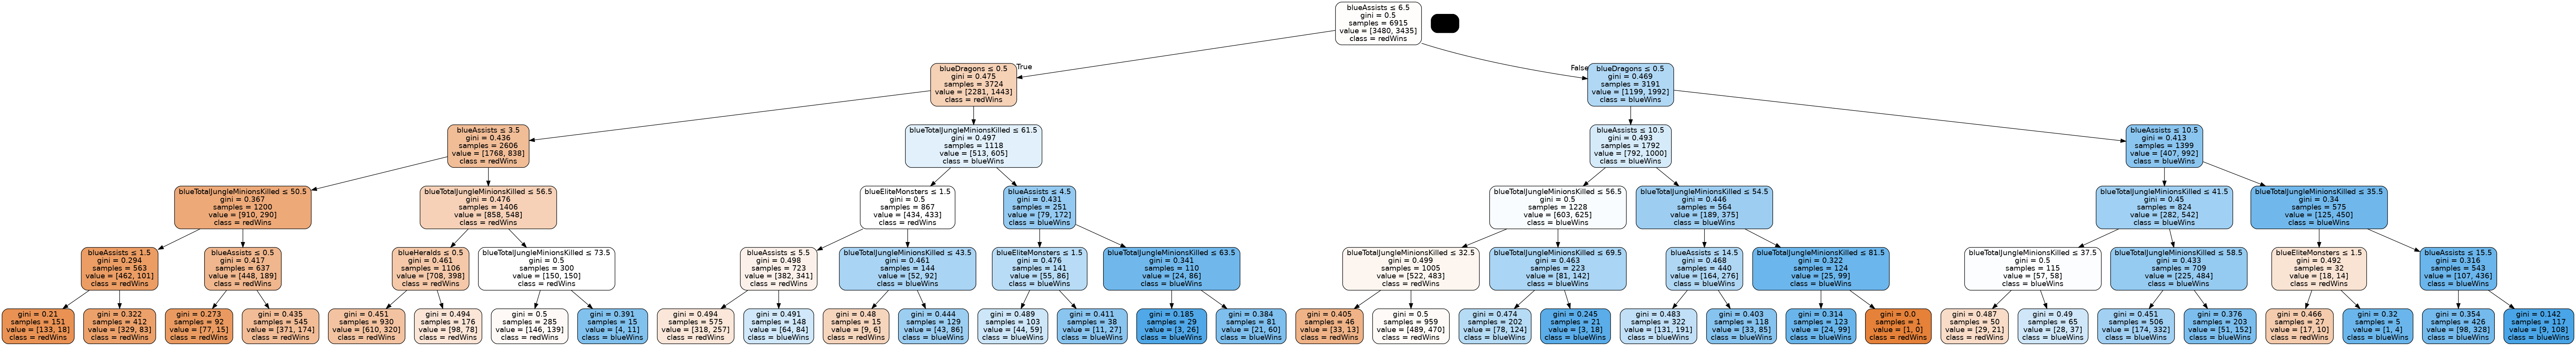

In [14]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True, 
                feature_names=using_cols, 
                class_names=['redWins','blueWins']
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('row_df.png')
Image(graph.create_png(), retina=True)